# Strain Mapping

This tutorial demonstrates different routes to obtain strain maps from scanning electron diffraction data.

The code functionality is illustrated using synthetic data, which is first generated using pyxem. This synthetic data represents a simple cubic crystal that is distorted to a tetragonal stucture. The intention is for this to provide an easy to understand illustration of the code functionality rather than to model any physical system.

This functionaility has been checked to run in pyxem-0.15.0 (April 2023). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

# Contents

1. <a href='#gen'> Setting up & Creating Synthetic Data</a>
2. <a href='#aff'> Image Affine Transform Based Mapping</a>
3. <a href='#vec'> Vector Based Mapping</a>

# <a id='gen'></a> 1. Setting up & Creating Synthetic Data

Import pyxem and other required libraries

In [1]:
%matplotlib inline
import pyxem as pxm
import numpy as np
import hyperspy.api as hs
import diffpy.structure
from matplotlib import pyplot as plt
from pyxem.generators.indexation_generator import IndexationGenerator
from diffsims.generators.diffraction_generator import DiffractionGenerator

In [2]:
hs.set_log_level('ERROR') # removes Warnings from hyperspy.

Define a structure for the creation of synthetic data.  We will start by showing how changing
the lattice parameter changes the diffraction spots. 

In [3]:
latt = diffpy.structure.lattice.Lattice(3,3,3,90,90,90)
atom = diffpy.structure.atom.Atom(atype='Ni',xyz=[0,0,0],lattice=latt)
structure = diffpy.structure.Structure(atoms=[atom],lattice=latt)

latt = diffpy.structure.lattice.Lattice(3.2,3.2,3,90,90,90)
atom = diffpy.structure.atom.Atom(atype='Ni',xyz=[0,0,0],lattice=latt)
structure2 = diffpy.structure.Structure(atoms=[atom],lattice=latt)

Simulate an electron diffraction pattern.  This just calculates the electron diffraction spots which should be visable based on the paramters given.  We simulate a 300 keV beam here. 

In [4]:
ediff = DiffractionGenerator(300.)
diffraction = ediff.calculate_ed_data(structure,
                                      reciprocal_radius=5.,
                                      max_excitation_error=0.025, shape_factor_width=5.0,
                                      with_direct_beam=False)
strained_diffraction = ediff.calculate_ed_data(structure2,
                                               reciprocal_radius=5.,
                                               max_excitation_error=0.025, shape_factor_width=5.0,
                                               with_direct_beam=False)

Check we have some spots. Notice that the material is strained in both x,y so the diffraction spots are all at smaller reciporical spacing. 

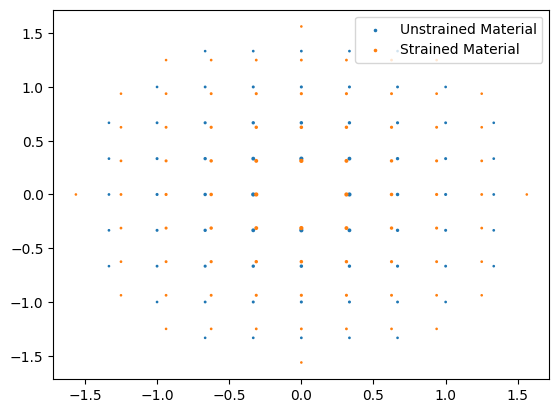

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1,1,)
diffraction.plot(ax=ax, label="Unstrained Material")
strained_diffraction.plot(ax=ax, label="Strained Material")
ax.legend()

We define a "detector" configuration here so that we can simulate the dataset.

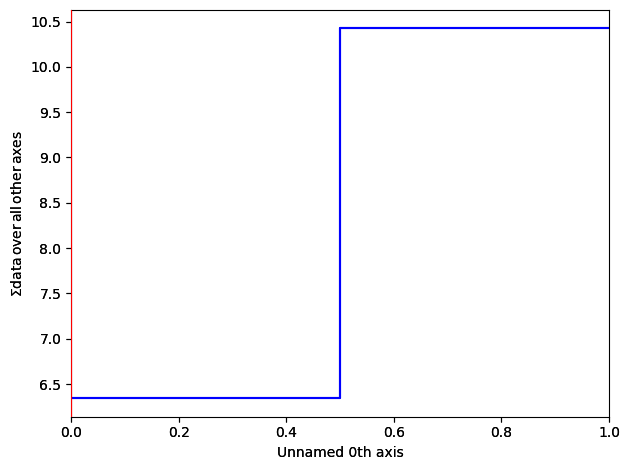

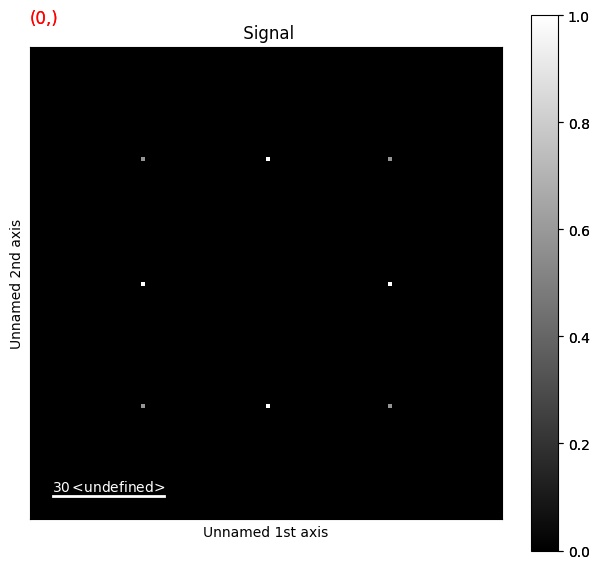

In [6]:

diffraction.calibration = 1e-2
pattern = diffraction.get_diffraction_pattern(shape = (128,128),
                                              sigma = 0)

strained_diffraction.calibration = 1e-2
pattern2 = strained_diffraction.get_diffraction_pattern(shape = (128,128),
                                              sigma = 0)
pxm.signals.Diffraction2D([pattern, pattern2]).plot()

Define a distorted structure and simulate diffraction.  Note that this structure is fairly unphysical but it does give us something to fit to.

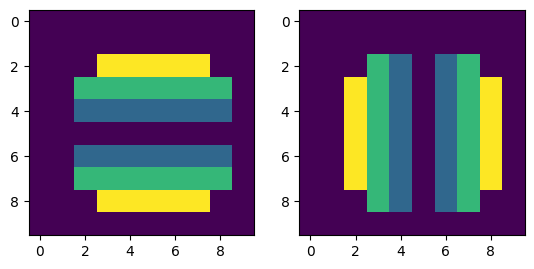

In [7]:
from skimage.draw import disk
distortion_x = np.zeros((10, 10))
distortion_y = np.zeros((10, 10))

xx, yy = disk(center=(5, 5), radius=4, shape=(20, 20))

distortion_x[xx,yy]= np.abs(np.abs(xx-10)-5)
distortion_y[xx,yy]= np.abs(np.abs(yy-10)-5)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(distortion_x)
axs[1].imshow(distortion_y)

In [8]:
data = np.empty((10,10,128,128))

for ind in np.ndindex((10,10)):
    dx = distortion_x[ind]*.1
    dy = distortion_y[ind]*.1
    latt = diffpy.structure.lattice.Lattice(3+dx,3+dy,3,90,90,90)
    atom = diffpy.structure.atom.Atom(atype='Ni',xyz=[0,0,0],lattice=latt)
    structure = diffpy.structure.Structure(atoms=[atom],lattice=latt)
    diffraction = ediff.calculate_ed_data(structure, reciprocal_radius=5.,
                                          max_excitation_error=0.025,
                                          with_direct_beam=True)
    diffraction.calibration = 1e-2
    data[ind] = diffraction.get_diffraction_pattern((128,128),sigma=4)

dp = pxm.signals.ElectronDiffraction2D(data)

dp = dp.shift_diffraction(7,8) #shifting diffraction patterns to simulate real_effects

dp = dp+np.random.random((10,10,128,128))*.1

[########################################] | 100% Completed |  0.1s


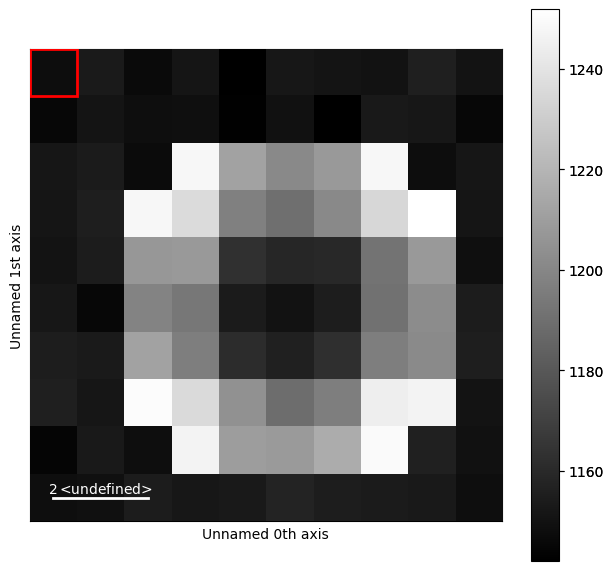

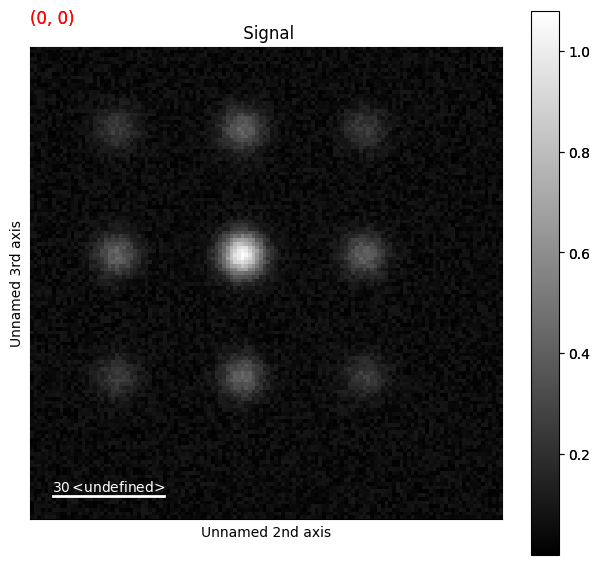

In [9]:
%matplotlib inline
dp.plot()

## Calibrating the Diffraction Pattern

It is important that we keep track of the center of the diffraction pattern as well as the calibration. Lets consider the diffraction pattern above.

In [10]:
dp.set_diffraction_calibration(1e-2) # known from simulation
dp.beam_energy = 300 #kEv
dp.unit = "k_A^-1"

In [11]:
shifts, aligned = dp.center_direct_beam(method="blur",half_square_width=20,sigma=5, return_shifts=True, inplace=False)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


Navigation axis name,size,index,offset,scale,units
,10,0,0.0,1.0,
,10,0,0.0,1.0,
Signal axis name,size,,offset,scale,units
kx,128,,-0.64,0.01,k_A^-1
ky,128,,-0.64,0.01,k_A^-1


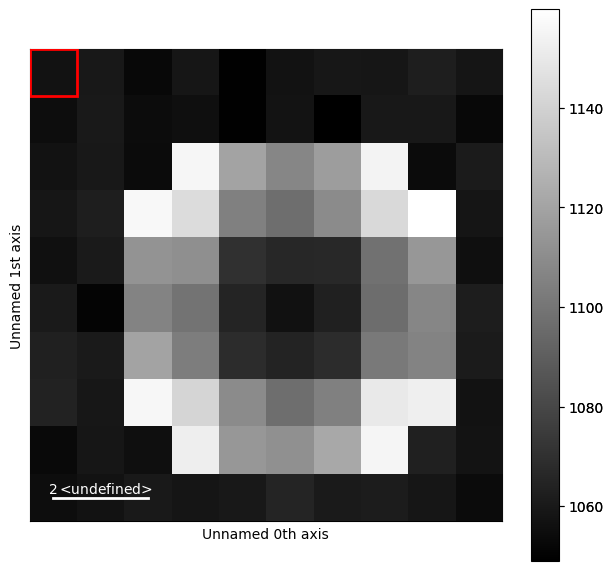

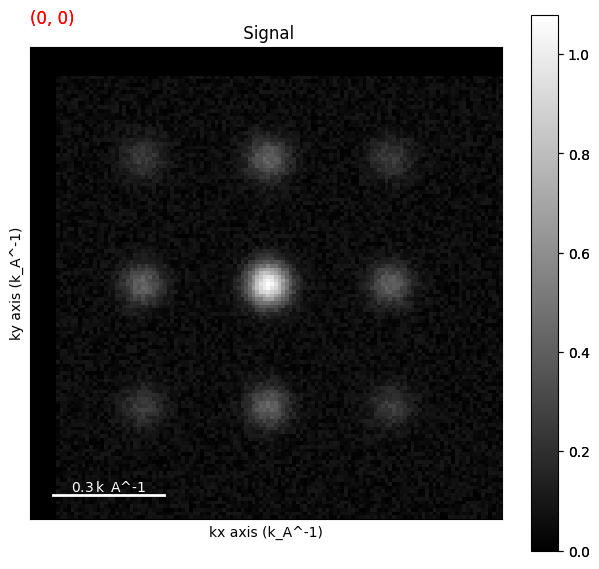

In [12]:
aligned.plot()
aligned.axes_manager

## Template Matching

A common way to find spots in a diffraction pattern is through template matching.  Template matching involves creating a template of one of the diffraction spots and convolving it with the entire dataset.  Usually this is done using a flat disk or a summed image of the zero beam.  Often times reducing the noise in the dataset is useful as it 

There are a couple of ways to acomplish this is pyxem. 

The first is to use the `template_match_disk` function which uses the normalized_cross_correlation to find shere some diffraction spot is.  We can think of this as the template being slid across the image and multiplied at every point.  The result is that objects similar to the template are very visable in the filtered dataset. 

There are multiple ways to do this:

1. Use the vaccum probe as a template and convolve the vaccum probe with the image
2. Use the 

[########################################] | 100% Completed |  0.2s


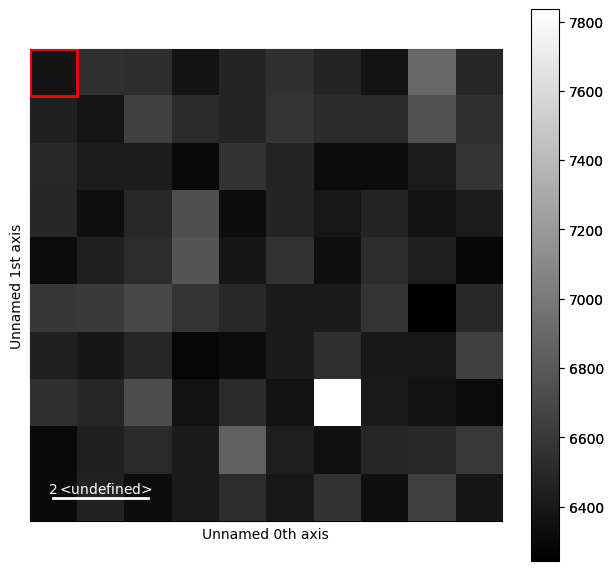

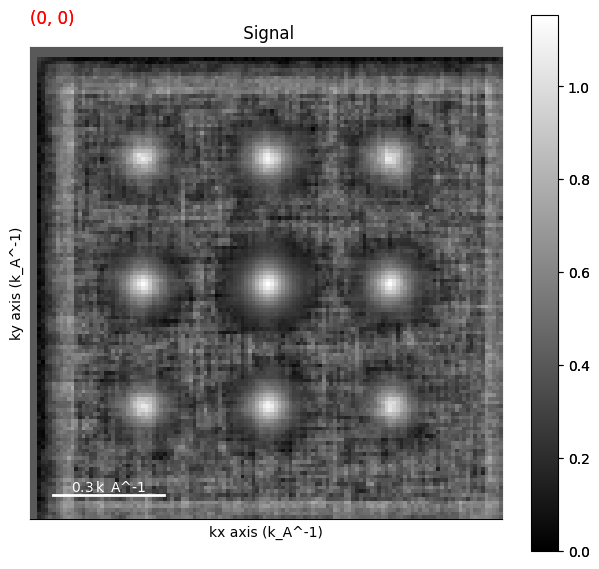

In [13]:
matched = aligned.template_match_disk(disk_r=5) # the disk_r should be equal to the size of the diffraction spots. 
matched.plot()

## Peak Finding
We can then find the position of the peaks using the `hyperspy.Signal2D.find_peaks()` method.  There is an interactive form of this method as well which makes defining the proper settings a little bit easier. 

In [14]:
%matplotlib notebook
matched.find_peaks()

<BaseSignal, title: , dimensions: (10, 10|)>

In [15]:
peaks = matched.find_peaks(threshold=1.0, distance=5, interactive=False)

[########################################] | 100% Completed |  0.2s


## Converting Peaks to Diffraction Vectors

We then need to take the peaks identified and transform them into diffraction Vectors. We can construct the signal using the following code.  Note that the center of the diffraction pattern and the calibration need to be passed once again. We can take these from the diffraction signal.

In [16]:
center = [a.offset/a.scale*-1 for a in matched.axes_manager.signal_axes] # should be the center of the pattern now...

calibration = matched.axes_manager.signal_axes[0].scale

vectors = pxm.signals.DiffractionVectors.from_peaks(peaks,center = center, calibration=calibration)


[########################################] | 100% Completed |  0.1s


## Filter the Diffraction Vectors

We want to only return the diffraction vectors which are within some distance of a basis set of diffraction vectors.  This basis set can be just be a single set of diffraction spots but ideally more than 2 spots will be used.  This allows for the least squares fitting to also return a residual.  In many cases this is prefered as it allows outliers to be identified as points with high residuals.  Note that in some cases, using too many spots can also be probalematic as low intensity spots are harder to fit.  In those cases a weight parameter is also allowed to help refine the fitting. 

Defining the basis set of vectors can be done in multiple different ways.  

1. Define a basis from a known basis set of vectors.  Using the known lattice parameter for the material it is possible to define the proper basis set for the material.

2. Define the basis from an unstrained part of the material. 


In most cases the secound way is easier and prefered over the first.  It is less dependent on the calibration and things like elliptical distortion in the diffraction pattern will show up as strains in the first case and a very high quality of experiment is necessary.


In [17]:
# Get the basis vectors from an unstrained part of the material. 
basis = vectors.inav[1:2,1:2]
basis.filter_magnitude(min_magnitude =0.1, max_magnitude=1)# remove the zero_beam
basis_array = basis.data[0,0]

[########################################] | 100% Completed |  0.1s


In [18]:
filtered_vectors = vectors.filter_basis(basis_array, distance =.2, inplace= False)

[########################################] | 100% Completed |  0.1s


In [19]:
from pyxem.generators.displacement_gradient_tensor_generator import get_DisplacementGradientMap

In [20]:
strain_map = get_DisplacementGradientMap(filtered_vectors, basis_array)

[########################################] | 100% Completed |  0.1s


In [21]:
maps = strain_map.get_strain_maps()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


<IPython.core.display.Javascript object>


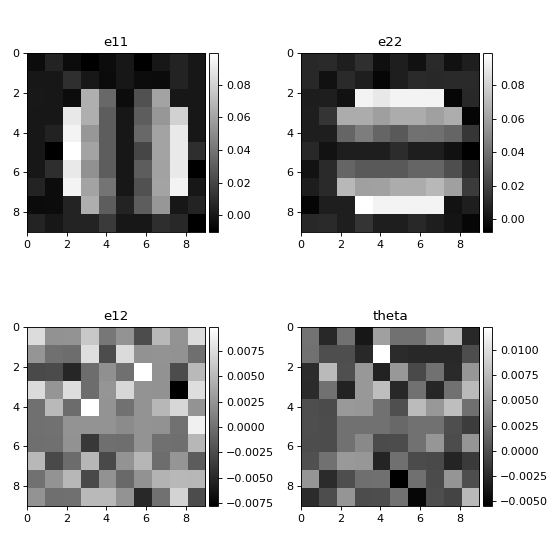

In [22]:
import matplotlib.pyplot as plt
f= plt.figure(figsize=(7,7))
hs.plot.plot_images(maps,per_row=2,fig=f,
                    label=["e11","e22", "e12", "theta"],tight_layout=True)
plt.show()